In [278]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [279]:
def f(x):
    return 3*x**2 - 4*x + 5

In [280]:
xs = np.arange(-5, 5, 0.25)

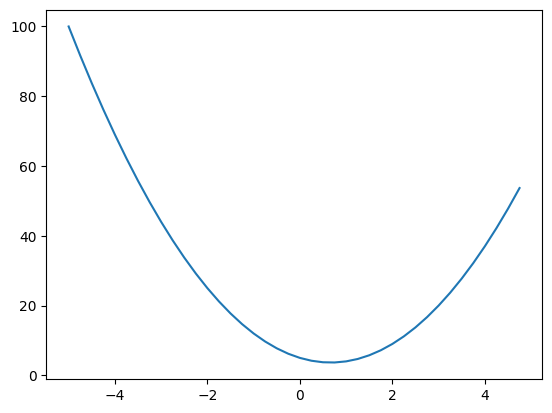

In [281]:
xs
ys = f(xs)
plt.plot(xs, ys)

In [282]:
# Derivates
h = 0.000001
x = 2/3
(f(x+h) - f(x))/h

2.999378523327323e-06

In [283]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope', (d1-d2)/h)

d1 4.0
d2 3.999699999999999
slope 3.000000000010772


In [348]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):

        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):

        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
 
    def __pow__(self, other):

        assert isinstance(other, (int, float)), "Only supporting int/ float division for now"
        out = Value(self.data ** other, (self, ), f"**{other}")

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        
        out._backward = _backward
        return out
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self, other): # self / other   
        out = self * other**-1
        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other
    
    def tanh(self):
         
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):

        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.grad * out.data
        
        out._backward = _backward
        return out

    def backward(self):
        # topological sort for managing gradient dependencies

        topo = []
        visited = set()

        def build_topo(v): 
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [334]:
from graphviz import Digraph

def trace(root):

    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}, filename="DigraphView.svg") # LR -> left to right direction

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape="record") # node for any value
        if n._op: # node for Value obtained from any operation
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the operation node of n2, which is the also the operation node of result of n1 and n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [286]:
h = 0.000001

a = Value(2.0, label='a')
b = Value(-1, label='b')
c = Value(4.0, label='c')
e = Value(10.0, label='e')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

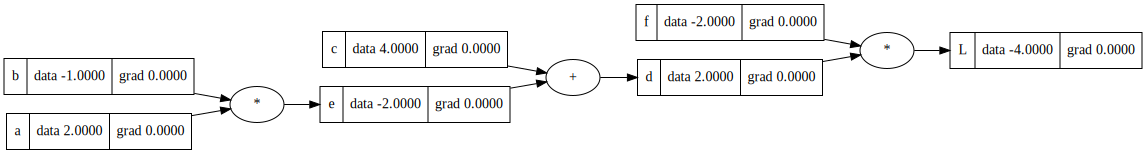

In [287]:
draw_dot(L)

In [288]:
def lol():

    h = 0.000001

    a = Value(2.0, label='a')
    b = Value(-1, label='b')
    c = Value(4.0, label='c')
    e = Value(10.0, label='e')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0 + h, label='a')
    b = Value(-1, label='b')
    c = Value(4.0, label='c')
    e = Value(10.0, label='e')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

lol()

2.000000000279556


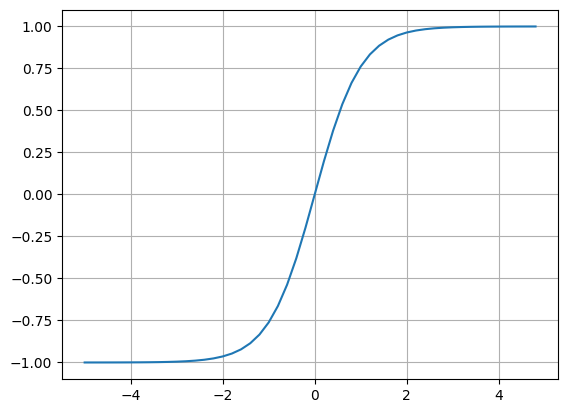

In [289]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid();

In [290]:
# 2 dimension neuron
# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of the neuron
b = Value(6.7, label="b")

x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b; n.label="n"
o = n.tanh(); o.label="o"

## Backpropagation

In [291]:
# o = tanh(n)
# do/dn = 1 - o**2
1 - o.data ** 2

0.6347395899824584

In [292]:
o.grad = 1.0
o.data

0.6043677771171636

In [293]:
n.grad = 0.6347395899824584

In [294]:
x1w1x2w2.grad = 0.6347395899824584
b.grad = 0.6347395899824584

In [295]:
x1w1.grad = 0.6347395899824584
x2w2.grad = 0.6347395899824584

In [296]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [297]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

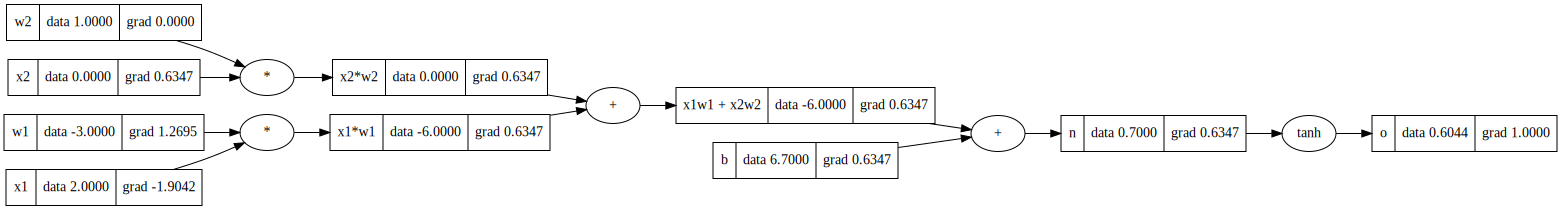

In [298]:
draw_dot(o)

In [299]:
# with backpropagation implemented
# 2 dimension neuron
# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of the neuron
b = Value(6.7, label="b")

x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b; n.label="n"
o = n.tanh(); o.label="o"

In [300]:
o.grad = 1

In [301]:
o._backward()

In [302]:
n._backward()

In [303]:
b._backward()

In [304]:
x1w1x2w2._backward()

In [305]:
x1w1._backward()
x2w2._backward()

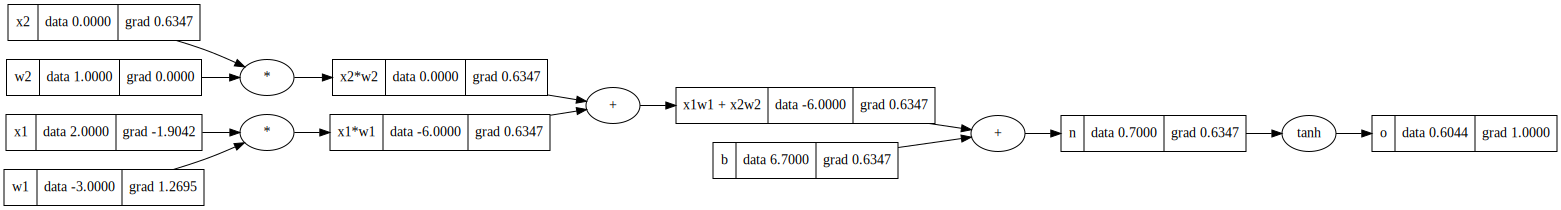

In [306]:
draw_dot(o)

In [307]:
# topological sort for managing gradient dependencies

topo = []
visited = set()

def build_topo(v): 
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
    topo.append(v)

build_topo(o)
print(topo)

for node in reversed(topo):
    node._backward()

[Value(data=0.0), Value(data=1.0), Value(data=0.0), Value(data=-3.0), Value(data=2.0), Value(data=-6.0), Value(data=-6.0), Value(data=6.7), Value(data=0.7000000000000002), Value(data=0.6043677771171636)]


In [308]:
o.backward()

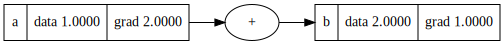

In [309]:
a = Value(1.0, label='a')
b = a + a; b.label = 'b'

b.backward()
draw_dot(b)
# the gradient of a should be 2

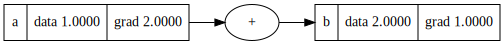

In [310]:
# after fixing the _backward()
a = Value(1.0, label='a')
b = a + a; b.label = 'b'

b.backward()
draw_dot(b)
# the gradient of a should be 2

In [311]:
# extra operations

a = Value(1)
b = Value(2)
print(3 * x)
print(a / b)
print(b - a)

2.0
Value(data=0.5)
Value(data=1)


In [349]:
# another implementation of tanh

x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of the neuron
b = Value(6.7, label="b")

x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b; n.label="n"

# ---------------------------------
e = (2*n).exp()
o = (e - 1)/(e + 1)

o.label="o"
o.backward()
# ---------------------------------

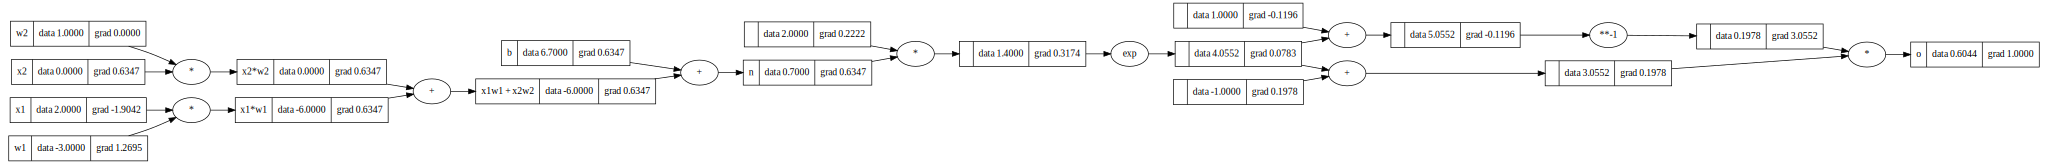

In [350]:
draw_dot(o)

In [368]:
# doing the same in PyTorch

import torch

x1 = torch.Tensor([2.0]).double() ;x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ;x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ;w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ;w2.requires_grad = True
b = torch.Tensor([6.7]).double() ;b.requires_grad = True

n = x1 * w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('--------')
print('x1', x1.grad.item()) # .grad -> gives scalar and .item() -> gives value of scalar
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())

0.6043676560501806
--------
x1 -1.9042192089612318
w1 1.2694794726408212
x2 0.6347397363204106
w2 0.0


In [414]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        
        # w * x + b
        act = sum([xi*wi for xi, wi in zip(x, self.w)], self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [neuron(x) for neuron in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts: list):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [415]:
x = [2.0, 3.0, -1.0]
mlp = MLP(3, [4, 4, 1])
mlp(x)

Value(data=-0.31205661288639147)

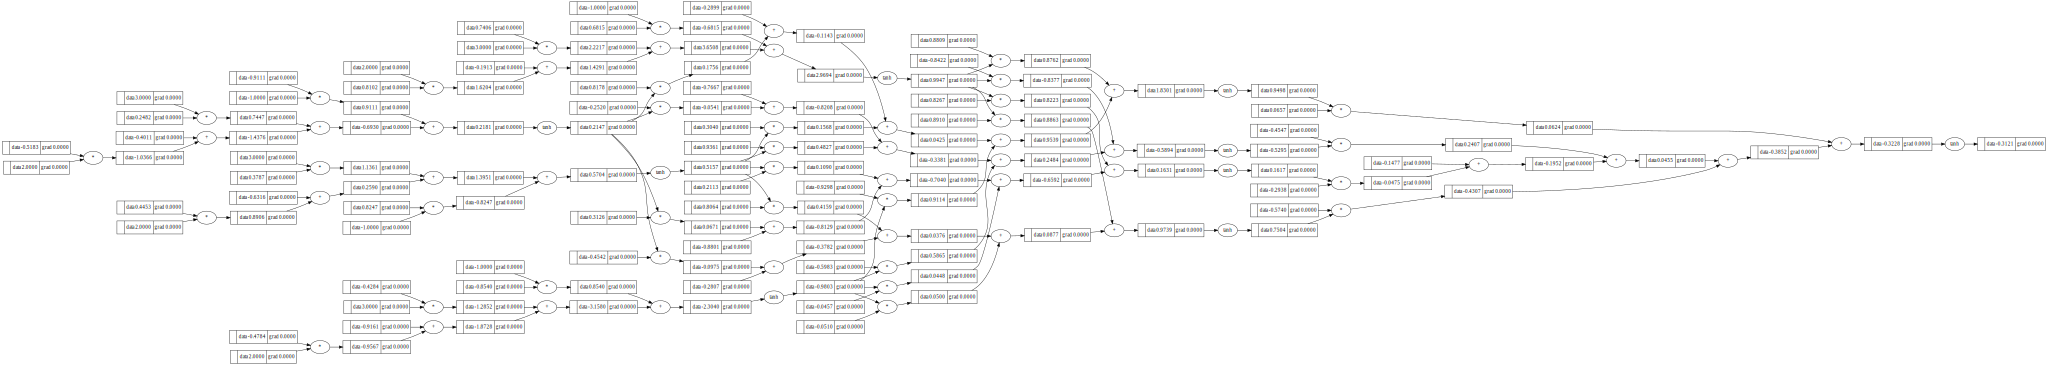

In [416]:
draw_dot(mlp(x))

In [417]:
# working with small dataset

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [mlp(x) for x in xs]
ypred

[Value(data=-0.31205661288639147),
 Value(data=-0.4617123162033332),
 Value(data=-0.4688989189980643),
 Value(data=0.5149685925419375)]

In [418]:
# mean squared error loss

loss = sum((yout - ygt) **  2 for ygt, yout in zip(ys, ypred))
loss.backward()

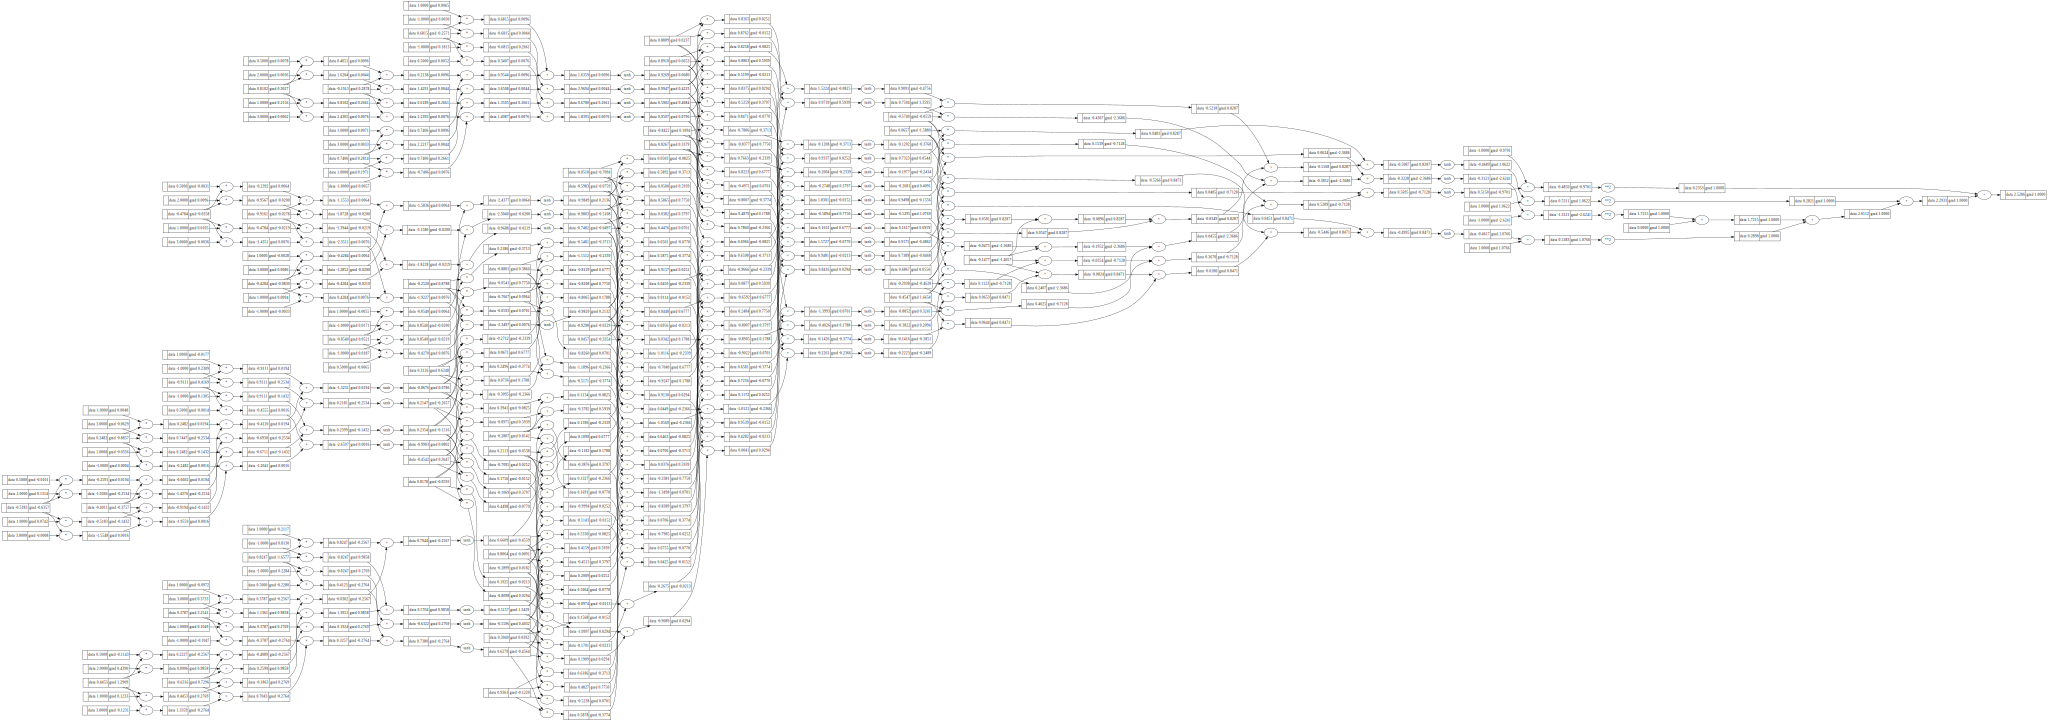

In [419]:
draw_dot(loss)

In [424]:
mlp.layers[0].neurons[0].w[0].grad, mlp.layers[0].neurons[0].w[0].data, 

(-0.6357310889373616, -0.5182767911692037)

In [423]:
mlp.parameters()

[Value(data=-0.5182767911692037),
 Value(data=0.24822644455362752),
 Value(data=-0.9110865289182979),
 Value(data=-0.40109222274261414),
 Value(data=0.4453074288043162),
 Value(data=0.3786858740805372),
 Value(data=0.8246628846369066),
 Value(data=-0.6315750186620259),
 Value(data=-0.47835044538335647),
 Value(data=-0.4283981101775691),
 Value(data=-0.8540179274019948),
 Value(data=-0.9160750559490158),
 Value(data=0.8101830271932609),
 Value(data=0.7405759420219911),
 Value(data=0.6814711895226584),
 Value(data=-0.19125232402199233),
 Value(data=0.312579579827984),
 Value(data=0.21128762835260617),
 Value(data=-0.0456786054396181),
 Value(data=0.8266873016711858),
 Value(data=-0.8800582004931123),
 Value(data=-0.25200573324462017),
 Value(data=0.9360516776435237),
 Value(data=-0.5982791089046005),
 Value(data=-0.842167938149506),
 Value(data=-0.7666942637065137),
 Value(data=-0.45421580785083226),
 Value(data=0.8064147668899981),
 Value(data=-0.05103719865616019),
 Value(data=0.890970

In [ ]:
display_pdf